In [1]:

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import warnings
warnings.filterwarnings('ignore')


🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷
Method 1: DOS1 (Simple Dark Object Subtraction)
🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷

🚀 Starting DOS1 Atmospheric Correction
☀️  Sun Elevation: 50.0°
📊 Number of bands: 13
📏 Image shape: 5280 x 5281

🔍 Calculating Dark Objects:
   Band 1: Dark Object = 846.00 (≈ 0.0846)
   Band 2: Dark Object = 610.00 (≈ 0.0610)
   Band 3: Dark Object = 477.00 (≈ 0.0477)
   Band 4: Dark Object = 266.00 (≈ 0.0266)
   Band 5: Dark Object = 402.00 (≈ 0.0402)
   Band 6: Dark Object = 600.00 (≈ 0.0600)
   Band 7: Dark Object = 659.00 (≈ 0.0659)
   Band 8: Dark Object = 567.00 (≈ 0.0567)
   Band 9: Dark Object = 667.00 (≈ 0.0667)
   Band 10: Dark Object = 308.00 (≈ 0.0308)
   Band 11: Dark Object = 6.00 (≈ 0.0006)
   Band 12: Dark Object = 416.00 (≈ 0.0416)
   Band 13: Dark Object = 193.00 (≈ 0.0193)

⚙️  Applying DOS1 correction:
   ✓ Band 1: Tv = 1.0000
   ✓ Band 2: Tv = 1.0000
   ✓ Band 3: Tv = 1.0000
   ✓ Band 4: Tv = 1.0000
   ✓ Band 5: Tv = 1.0000
   ✓ Band 6: Tv = 1.0000
   ✓

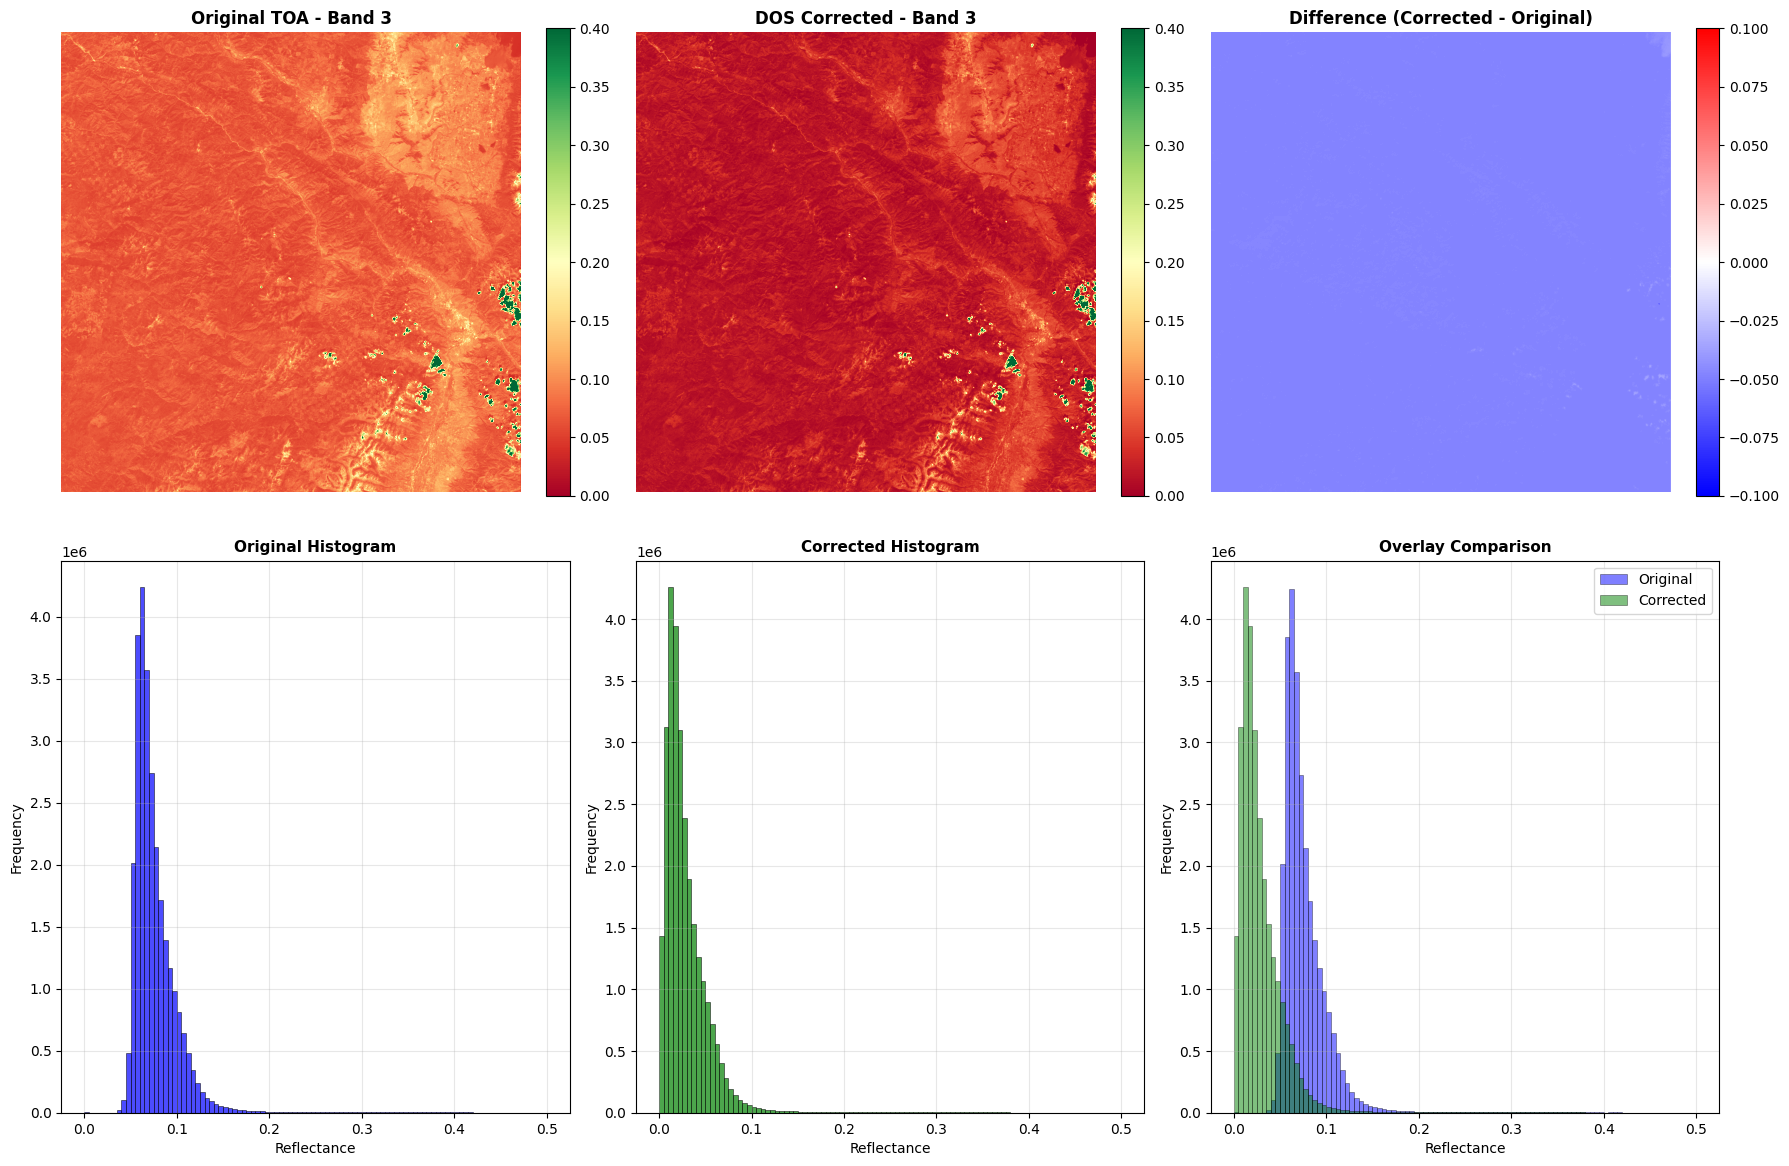


📊 Statistical Summary:
Metric               Original        Corrected       Change         
-----------------------------------------------------------------
Mean                 0.0772          0.0295          -0.0477        
Std Dev              0.0360          0.0360          -0.0000        
Min                  0.0000          0.0000          0.0000         
Max                  1.2011          1.0000          -0.2011        

✅ All corrections completed successfully!

💡 Method Selection Guide:
   • DOS1: Fastest, suitable for quick preprocessing
   • DOS2: Higher accuracy, recommended for most applications
   • Water-Masked: Best accuracy if image contains water


In [2]:
class DOSCorrector:
    def __init__(self, percentile=1, dos_method='DOS1'):
        """
        DOS Atmospheric Correction for Sentinel-2 TOA (scaled by 10000)
        
        Parameters:
        -----------
        percentile : float
            Percentile for Dark Object identification (typically 1)
        dos_method : str
            'DOS1': Simplest (only subtracts path radiance)
            'DOS2': Includes Rayleigh scattering
            'DOS3': Includes Rayleigh + Aerosol scattering
            'DOS4': More complete model
        """
        self.percentile = percentile
        self.dos_method = dos_method
        
        # Rayleigh optical thickness coefficients for DOS2-4
        self.rayleigh_thickness = {
            0: 0.367,  # B1 - Coastal aerosol
            1: 0.267,  # B2 - Blue
            2: 0.183,  # B3 - Green
            3: 0.106,  # B4 - Red
            4: 0.058,  # B5 - Red Edge 1
            5: 0.033,  # B6 - Red Edge 2
            6: 0.020,  # B7 - Red Edge 3
            7: 0.011,  # B8 - NIR
            8: 0.008,  # B8A - Narrow NIR
            9: 0.006,  # B9 - Water vapour
            10: 0.002, # B10 - SWIR - Cirrus
            11: 0.001, # B11 - SWIR 1
            12: 0.0005 # B12 - SWIR 2
        }
    
    def calculate_dark_object_per_band(self, image_array, valid_mask=None):
        """
        Calculate dark object value for each band
        
        Returns:
        --------
        dark_values : array
            Dark object values in scaled format (0-10000)
        """
        n_bands = image_array.shape[0]
        dark_values = []
        
        for band_idx in range(n_bands):
            band_data = image_array[band_idx].astype(np.float64)
            
            # Apply mask or filter valid values
            if valid_mask is not None:
                valid_pixels = band_data[valid_mask]
            else:
                # Remove NoData, zero, and negative values
                valid_pixels = band_data[(band_data > 0) & (band_data < 15000)]
            
            # Calculate percentile
            if len(valid_pixels) > 100:
                dark_value = np.percentile(valid_pixels, self.percentile)
            else:
                dark_value = 100  # Default value (equivalent to 0.01 reflectance)
                print(f"⚠️  Warning: Band {band_idx+1} - Insufficient valid pixels")
            
            dark_values.append(dark_value)
            print(f"   Band {band_idx+1}: Dark Object = {dark_value:.2f} (≈ {dark_value/10000:.4f})")
        
        return np.array(dark_values)
    
    def calculate_transmittance(self, band_idx, sun_elevation=45.0):
        """
        Calculate atmospheric transmittance
        
        Parameters:
        -----------
        band_idx : int
            Band number (0-based)
        sun_elevation : float
            Sun elevation angle (degrees)
        
        Returns:
        --------
        Tv : float
            Atmospheric transmittance
        """
        if self.dos_method == 'DOS1':
            # Simplest method: Assume transmittance = 1
            return 1.0
        
        # Calculate cosine of solar zenith angle
        sun_zenith = 90.0 - sun_elevation
        cos_sz = np.cos(np.radians(sun_zenith))
        
        # Get optical thickness
        tau_r = self.rayleigh_thickness.get(band_idx, 0.1)
        
        if self.dos_method == 'DOS2':
            # Only Rayleigh scattering
            return np.exp(-tau_r / cos_sz)
        
        elif self.dos_method == 'DOS3':
            # Rayleigh + Aerosol optical depth
            tau_a = 0.08  # Average aerosol value
            return np.exp(-(tau_r + tau_a) / cos_sz)
        
        elif self.dos_method == 'DOS4':
            # More complex model
            tau_a = 0.1
            return np.exp(-(tau_r + tau_a) / cos_sz) * 0.95
        
        return 1.0
    
    def simple_dos(self, image_path, output_path, sun_elevation=45.0):
        """
        Standard DOS correction
        
        Parameters:
        -----------
        image_path : str
            Input TOA image path (int16, scaled by 10000)
        output_path : str
            Path to save corrected image
        sun_elevation : float
            Sun elevation angle (degrees) - read from metadata
        """
        print(f"\n{'='*60}")
        print(f"🚀 Starting {self.dos_method} Atmospheric Correction")
        print(f"{'='*60}")
        print(f"☀️  Sun Elevation: {sun_elevation}°")
        
        with rasterio.open(image_path) as src:
            image_array = src.read()
            profile = src.profile.copy()
            n_bands = image_array.shape[0]
            
            print(f"📊 Number of bands: {n_bands}")
            print(f"📏 Image shape: {image_array.shape[1]} x {image_array.shape[2]}")
            print(f"\n🔍 Calculating Dark Objects:")
            
            # Calculate dark objects
            dark_values = self.calculate_dark_object_per_band(image_array)
            
            # Output array
            corrected_array = np.zeros_like(image_array, dtype=np.float32)
            
            print(f"\n⚙️  Applying {self.dos_method} correction:")
            
            for band_idx in range(n_bands):
                # Read band
                band_data = image_array[band_idx].astype(np.float64)
                
                # Calculate transmittance
                Tv = self.calculate_transmittance(band_idx, sun_elevation)
                
                # DOS formula: ρ_surface = (ρ_TOA - ρ_dark) / Tv
                # All values are in scale 10000
                corrected_band = (band_data - dark_values[band_idx]) / Tv
                
                # Clip to valid range (0-10000)
                corrected_band = np.clip(corrected_band, 0, 10000)
                
                corrected_array[band_idx] = corrected_band
                
                print(f"   ✓ Band {band_idx+1}: Tv = {Tv:.4f}")
            
            # Convert to int16 for saving
            corrected_array = corrected_array.astype(np.int16)
            
            # Save file with NoData = -9999 to avoid interference with zero
            profile.update({
                'dtype': rasterio.int16,
                'nodata': -9999,
                'compress': 'lzw'
            })
            
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(corrected_array)
            
            print(f"\n✅ Corrected image saved: {output_path}")
            print(f"{'='*60}\n")
            
            return corrected_array, dark_values
    
    def dos_with_water_mask(self, image_path, output_path, sun_elevation=45.0,
                          green_band_idx=2, nir_band_idx=7):
        """
        DOS using water mask for more accurate dark object identification
        
        Parameters:
        -----------
        green_band_idx : int
            Green band number (for S2: B3 = index 2)
        nir_band_idx : int
            NIR band number (for S2: B8 = index 7)
        """
        print(f"\n{'='*60}")
        print(f"🌊 Starting Water-Masked {self.dos_method} Correction")
        print(f"{'='*60}")
        
        with rasterio.open(image_path) as src:
            image_array = src.read()
            profile = src.profile.copy()
            n_bands = image_array.shape[0]
            
            # Calculate NDWI: (Green - NIR) / (Green + NIR)
            print("🔍 Calculating NDWI for water detection...")
            green = image_array[green_band_idx].astype(np.float64)
            nir = image_array[nir_band_idx].astype(np.float64)
            
            denominator = green + nir
            denominator[denominator == 0] = 1.0
            
            ndwi = (green - nir) / denominator
            
            # Water mask: NDWI > 0.2 and valid values
            water_mask = (ndwi > 0.2) & (green > 0) & (nir > 0)
            water_pixels = np.sum(water_mask)
            total_pixels = water_mask.size
            
            print(f"💧 Water pixels: {water_pixels:,} ({100*water_pixels/total_pixels:.2f}%)")
            
            if water_pixels < 1000:
                print("⚠️  Warning: Insufficient water pixels. Using standard method.")
                return self.simple_dos(image_path, output_path, sun_elevation)
            
            # Calculate dark object from water pixels
            print(f"\n🔍 Calculating Dark Objects from water pixels:")
            dark_values = self.calculate_dark_object_per_band(image_array, water_mask)
            
            # Apply correction
            corrected_array = np.zeros_like(image_array, dtype=np.float32)
            
            print(f"\n⚙️  Applying correction:")
            for band_idx in range(n_bands):
                band_data = image_array[band_idx].astype(np.float64)
                Tv = self.calculate_transmittance(band_idx, sun_elevation)
                
                corrected_band = (band_data - dark_values[band_idx]) / Tv
                corrected_band = np.clip(corrected_band, 0, 10000)
                corrected_array[band_idx] = corrected_band
                
                print(f"   ✓ Band {band_idx+1}: Tv = {Tv:.4f}")
            
            # Save with NoData = -9999
            corrected_array = corrected_array.astype(np.int16)
            profile.update({
                'dtype': rasterio.int16,
                'nodata': -9999,
                'compress': 'lzw'
            })
            
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(corrected_array)
            
            print(f"\n✅ Water-masked correction completed: {output_path}")
            print(f"{'='*60}\n")
            
            return corrected_array, dark_values, water_mask
    
    def plot_comparison(self, original_path, corrected_path, band_idx=3):
        """
        Visual comparison between original and corrected images
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        with rasterio.open(original_path) as src:
            original = src.read(band_idx).astype(np.float32) / 10000
        
        with rasterio.open(corrected_path) as src:
            corrected = src.read(band_idx).astype(np.float32) / 10000
        
        # First row: Images
        im1 = axes[0, 0].imshow(original, cmap='RdYlGn', vmin=0, vmax=0.4)
        axes[0, 0].set_title(f'Original TOA - Band {band_idx}', fontsize=12, weight='bold')
        axes[0, 0].axis('off')
        plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)
        
        im2 = axes[0, 1].imshow(corrected, cmap='RdYlGn', vmin=0, vmax=0.4)
        axes[0, 1].set_title(f'DOS Corrected - Band {band_idx}', fontsize=12, weight='bold')
        axes[0, 1].axis('off')
        plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
        
        # Difference
        diff = corrected - original
        im3 = axes[0, 2].imshow(diff, cmap='bwr', vmin=-0.1, vmax=0.1)
        axes[0, 2].set_title('Difference (Corrected - Original)', fontsize=12, weight='bold')
        axes[0, 2].axis('off')
        plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)
        
        # Second row: Histograms
        axes[1, 0].hist(original.flatten(), bins=100, alpha=0.7, color='blue', 
                       range=(0, 0.5), edgecolor='black', linewidth=0.5)
        axes[1, 0].set_title('Original Histogram', fontsize=11, weight='bold')
        axes[1, 0].set_xlabel('Reflectance', fontsize=10)
        axes[1, 0].set_ylabel('Frequency', fontsize=10)
        axes[1, 0].grid(alpha=0.3)
        
        axes[1, 1].hist(corrected.flatten(), bins=100, alpha=0.7, color='green',
                       range=(0, 0.5), edgecolor='black', linewidth=0.5)
        axes[1, 1].set_title('Corrected Histogram', fontsize=11, weight='bold')
        axes[1, 1].set_xlabel('Reflectance', fontsize=10)
        axes[1, 1].set_ylabel('Frequency', fontsize=10)
        axes[1, 1].grid(alpha=0.3)
        
        # Histogram comparison
        axes[1, 2].hist(original.flatten(), bins=100, alpha=0.5, color='blue',
                       range=(0, 0.5), label='Original', edgecolor='black', linewidth=0.5)
        axes[1, 2].hist(corrected.flatten(), bins=100, alpha=0.5, color='green',
                       range=(0, 0.5), label='Corrected', edgecolor='black', linewidth=0.5)
        axes[1, 2].set_title('Overlay Comparison', fontsize=11, weight='bold')
        axes[1, 2].set_xlabel('Reflectance', fontsize=10)
        axes[1, 2].set_ylabel('Frequency', fontsize=10)
        axes[1, 2].legend()
        axes[1, 2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Descriptive statistics
        print("\n📊 Statistical Summary:")
        print(f"{'Metric':<20} {'Original':<15} {'Corrected':<15} {'Change':<15}")
        print("-" * 65)
        print(f"{'Mean':<20} {np.mean(original):<15.4f} {np.mean(corrected):<15.4f} {np.mean(corrected)-np.mean(original):<15.4f}")
        print(f"{'Std Dev':<20} {np.std(original):<15.4f} {np.std(corrected):<15.4f} {np.std(corrected)-np.std(original):<15.4f}")
        print(f"{'Min':<20} {np.min(original):<15.4f} {np.min(corrected):<15.4f} {np.min(corrected)-np.min(original):<15.4f}")
        print(f"{'Max':<20} {np.max(original):<15.4f} {np.max(corrected):<15.4f} {np.max(corrected)-np.max(original):<15.4f}")


# ==================== Usage Example ====================

def main():
    """
    Complete usage example
    """
    # File paths
    input_toa = r"F:\AOI_Biomass_Sentinel2\S_New_ROI\Sentinel2\Mosaic_resample\Mosaic30m\Mosaic30.tif"
    output_dos1 = r"F:\AOI_Biomass_Sentinel2\S_New_ROI\Sentinel2\Mosaic_resample\Mosaic30m\sentinel2_dos1.tif"
    output_dos2 = r"F:\AOI_Biomass_Sentinel2\S_New_ROI\Sentinel2\Mosaic_resample\Mosaic30m\sentinel2_dos2.tif"
    output_dos_water = r"F:\AOI_Biomass_Sentinel2\S_New_ROI\Sentinel2\Mosaic_resample\Mosaic30m\sentinel2_dos_water.tif"
    
    # Sun elevation angle (read from metadata)
    # For Sentinel-2: Available in MTD_TL.xml file
    sun_elevation = 50.0  # Example: 55 degrees
    
    # ==================== Method 1: Simple DOS1 ====================
    print("\n" + "🔷" * 30)
    print("Method 1: DOS1 (Simple Dark Object Subtraction)")
    print("🔷" * 30)
    
    corrector_dos1 = DOSCorrector(percentile=1, dos_method='DOS1')
    corrected1, dark1 = corrector_dos1.simple_dos(
        input_toa,
        output_dos1,
        sun_elevation=sun_elevation
    )
    
    # ==================== Method 2: DOS2 with Rayleigh ====================
    print("\n" + "🔶" * 30)
    print("Method 2: DOS2 (with Rayleigh Scattering)")
    print("🔶" * 30)
    
    corrector_dos2 = DOSCorrector(percentile=1, dos_method='DOS2')
    corrected2, dark2 = corrector_dos2.simple_dos(
        input_toa,
        output_dos2,
        sun_elevation=sun_elevation
    )
    
    # ==================== Method 3: DOS with Water Mask ====================
    print("\n" + "🔵" * 30)
    print("Method 3: Water-Masked DOS (more accurate for images with water)")
    print("🔵" * 30)
    
    corrector_water = DOSCorrector(percentile=1, dos_method='DOS2')
    corrected3, dark3, mask = corrector_water.dos_with_water_mask(
        input_toa,
        output_dos_water,
        sun_elevation=sun_elevation,
        green_band_idx=2,  # B3 - Green
        nir_band_idx=7     # B8 - NIR
    )
    
    # ==================== Visual Comparison ====================
    print("\n📈 Generating visual comparisons...")
    
    # Compare DOS1
    corrector_dos1.plot_comparison(input_toa, output_dos1, band_idx=3)
    
    print("\n" + "="*60)
    print("✅ All corrections completed successfully!")
    print("="*60)
    
    # Method selection guide
    print("\n💡 Method Selection Guide:")
    print("   • DOS1: Fastest, suitable for quick preprocessing")
    print("   • DOS2: Higher accuracy, recommended for most applications")
    print("   • Water-Masked: Best accuracy if image contains water")


if __name__ == "__main__":
    main()